In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 'large'

In [2]:
L = 12  #Do not change: vectors below are for L=12 only

## Construct transfer matrix (eqn 57 in arXiv:1608.02563)

In [3]:
M = 5
cutoff = 0.99999

Define kinetic energy functional:
\begin{equation}
\xi\left(\overrightarrow p \right)  = \exp \left( 
    \frac{\overrightarrow{p} \cdot \overrightarrow{p} }{2 M} \right)
\end{equation}

In [4]:
def ke_functional(p):
    if np.dot(p, p) <= (cutoff *np.pi)**2:
        return np.exp(np.dot(p, p)/(2*M))
    else:
        return np.inf
# ke_functional([0.1, 0.1, 0.1])


Define:
\begin{align}
H_0 \left(\overrightarrow{p}, \overrightarrow{q} \right) 
&= \frac{\delta_{\overrightarrow{p},\overrightarrow{q}}}{\xi \left(\frac{2\pi}{L} \overrightarrow{p}\right) \xi \left(\frac{2\pi}{L} \overrightarrow{q}\right)} \\
V_0 \left(\overrightarrow{p}, \overrightarrow{q} \right) 
&= \frac{1}{\xi \left(\frac{2\pi}{L} \overrightarrow{p}\right) \xi \left(\frac{2\pi}{L} \overrightarrow{q}\right)} \\
V_n \left(\overrightarrow{p}, \overrightarrow{q} \right) 
&= \frac{M^n \left\{ 1 - \exp\left[ - \frac{1}{M} \left( \frac{2\pi}{L}  \left( p - q \right) \right)^2 \right]\right\}^n}{\xi \left(\frac{2\pi}{L} \overrightarrow{p}\right) \xi \left(\frac{2\pi}{L} \overrightarrow{q}\right)} 
\end{align}


Reduced transfer matrix projected onto A1 irrep

In [5]:
distinctvex = np.array([[0., 0., 0.], [0., 0., 0.523599], [0., 0.523599, 
  0.523599], [0.523599, 0.523599, 0.523599], [0., 0., 1.0472], [0., 
  0.523599, 1.0472], [0.523599, 0.523599, 1.0472], [0., 1.0472, 
  1.0472], [0., 0., 1.5708], [0.523599, 1.0472, 1.0472], [0., 
  0.523599, 1.5708], [0.523599, 0.523599, 1.5708], [1.0472, 1.0472, 
  1.0472], [0., 1.0472, 1.5708], [0.523599, 1.0472, 1.5708], [0., 0., 
  2.0944], [0., 0.523599, 2.0944], [1.0472, 1.0472, 
  1.5708], [0.523599, 0.523599, 2.0944], [0., 1.5708, 
  1.5708], [0.523599, 1.5708, 1.5708], [0., 1.0472, 
  2.0944], [0.523599, 1.0472, 2.0944], [1.0472, 1.5708, 
  1.5708], [1.0472, 1.0472, 2.0944], [0., 0., 2.61799], [0., 1.5708, 
  2.0944], [0., 0.523599, 2.61799], [0.523599, 1.5708, 
  2.0944], [0.523599, 0.523599, 2.61799], [1.5708, 1.5708, 
  1.5708], [0., 1.0472, 2.61799], [1.0472, 1.5708, 2.0944], [0.523599,
   1.0472, 2.61799], [0., 2.0944, 2.0944], [1.0472, 1.0472, 
  2.61799], [0.523599, 2.0944, 2.0944], [0., 1.5708, 
  2.61799], [1.5708, 1.5708, 2.0944], [0.523599, 1.5708, 2.61799]])
distinctvexDeg=np.array([48, 8, 4, 6, 8, 2, 2, 4, 8, 2, 2, 2, 6, 2, 1, 8, 2, 2, 2, 4, 2, 2, 1,2, 2, 8, 2, 2, 1, 2, 6, 2, 1, 1, 4, 2, 2, 2, 2, 1])

H0 = np.empty((len(distinctvex),len(distinctvex)))
V0 = np.empty((len(distinctvex),len(distinctvex)))
for j, p in enumerate(distinctvex):
    for k, q in enumerate(distinctvex):

        denominator = ke_functional(p) *ke_functional(q)

        # H0
        if (j == k):
            H0[j,k] = 1 / denominator
        else:
            H0[j,k] = 0

        # V0
        V0[j,k] = 48/np.sqrt(distinctvexDeg[j]*distinctvexDeg[k]) / denominator

#H0 = H0.reshape(40,40, order='C')
#V0 = V0.reshape(L**3, L**3, order='C')

## Compute eigenvalues of transfer matrix

In [6]:
c = 1.0  # can change coupling to change the spectrum

eigenvalues = np.linalg.eigvals(H0 + c *(4 *np.pi/(M *L**3)) *V0)

# drop elements == 0, sort from highest to lowest
eigenvalues = np.sort(eigenvalues[np.nonzero(eigenvalues)])[::-1] 
eta = -np.log(eigenvalues)

## Compute correlation functions

Change these values as needed:

In [7]:
t_tot = 560  #Maximum time computed (open BC)

In [8]:
Htot =  H0 + c *(4 *np.pi/(M *L**3)) *V0
Corr = np.empty((t_tot,len(distinctvex),len(distinctvex)))
meff = np.empty((t_tot,len(distinctvex),len(distinctvex)))
Corr[0] = Htot

# Correlation function given by applying transfer matrix t times: C(t) = [e^(-H)]^t
for t in range(t_tot-1):  
    Corr[t+1] = np.matmul(Corr[t],Htot)
    meff[t] = np.log(Corr[t]/Corr[t+1])

## Evaluate GEVP

Change these values as needed:

In [9]:
n_ops = 12  #Number of ops to be plotted

Plot effective masses for diagonal entries of $C_{ij}(t)$; dashed lines correspond to exact energy spectrum

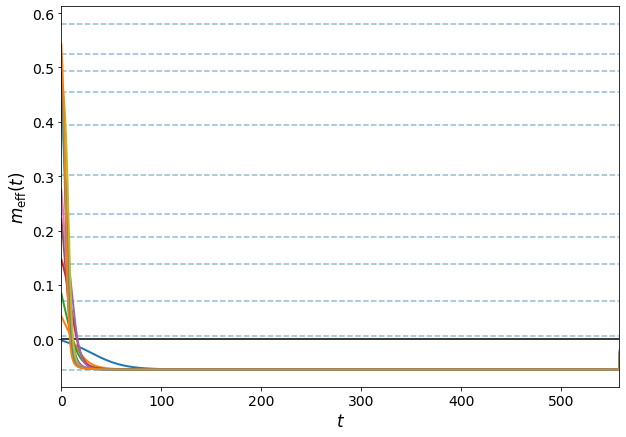

In [10]:
etax = range(t_tot)

fig, ax = plt.subplots()

[ax.axhline(y=et, ls='--', alpha=0.5) for et in eta[:n_ops]]
ax.axhline(y=0, color='k')
[ax.plot(etax, meff[:,k,k], lw=2) for k in range(n_ops)]
ax.set_xlim([0, t_tot-2])
#ax.set_ylim(-0.1, 0.1)
plt.xlabel('$t$')
plt.ylabel('$m_\mathrm{eff}(t)$')
plt.show()

Change these values as needed:

In [11]:
t_0 = 5 #Reference time for evaluating GEVP
n_ops = 16  #Number of operators to be included in GEVP

In [12]:
#Cholesky decomposition: C = LL^T
Corr_sqrt = np.linalg.cholesky(Corr[t_0])[:n_ops,:n_ops]  

# solution to GEVP: eigs[L^-1(t_0).C(t).L(t_0)]
Corr_gevp = [np.sort(np.linalg.eigvals(np.einsum('ij,jk,kl', np.linalg.inv(Corr_sqrt), Corr[t,:n_ops,:n_ops], Corr_sqrt))) for t in range(t_tot)] 

meff_gevp = np.array([np.log(Corr_gevp[t]/Corr_gevp[t+1]) for t in range(t_tot-1)])

Plot effective masses for solutions to GEVP; dashed lines correspond to exact energy spectrum

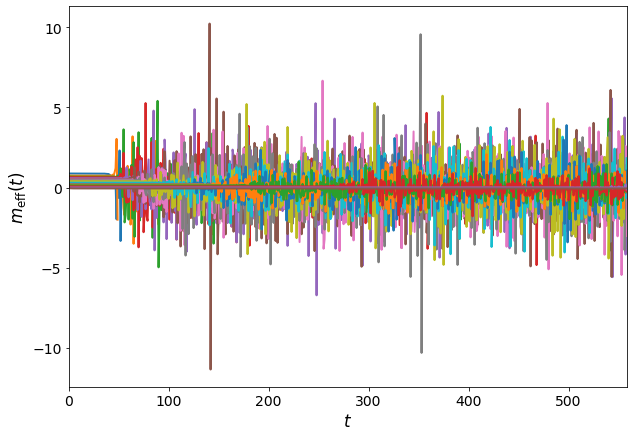

In [13]:
etax = range(t_tot-1)

fig, ax = plt.subplots()

[ax.axhline(y=et, ls='--', alpha=0.5) for et in eta[:10]]
ax.axhline(y=0, color='k')
[ax.plot(etax, meff_gevp[:,k], lw=2) for k in range(n_ops)]
ax.set_xlim([0, t_tot-2])
#ax.set_ylim([-0.1, 0.2])

plt.xlabel('$t$')
plt.ylabel('$m_\mathrm{eff}(t)$')
plt.show()